# **1. Install packages**

In [3]:
%%capture
!pip install torchinfo

# **2. Import libraries**

In [4]:
# ============================
# Importing Libraries
# ============================

# Data Handling
import os
import random
import pandas as pd
import numpy as np
from collections import OrderedDict
from pathlib import Path
from typing import Dict, List

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

# Machine Learning Preprocessing
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Deep Learning Frameworks
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.models import vit_b_16, ViT_B_16_Weights

# Progress Bar
from tqdm.auto import tqdm

# Warnings
import warnings
warnings.filterwarnings("ignore")


# **3. Load data and EDA**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Total Images
IMAGE_PATH = Path("/content/drive/MyDrive/files")

IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*/*/*.jpg"))

print(f'Total Images = {len(IMAGE_PATH_LIST)}')

Total Images = 87


In [7]:
# number of images per class.
classes = os.listdir(IMAGE_PATH)
classes = sorted(classes)

print("**" * 20)
print(" " * 10, f"Total Classes = {len(classes)}")
print("**" * 20)

for c in classes:
    total_images_class = list(Path(os.path.join(IMAGE_PATH, c)).glob("*/*.jpg"))
    print(f"* {c}: {len(total_images_class)} images")

****************************************
           Total Classes = 3
****************************************
* acne: 30 images
* bags: 27 images
* redness: 30 images


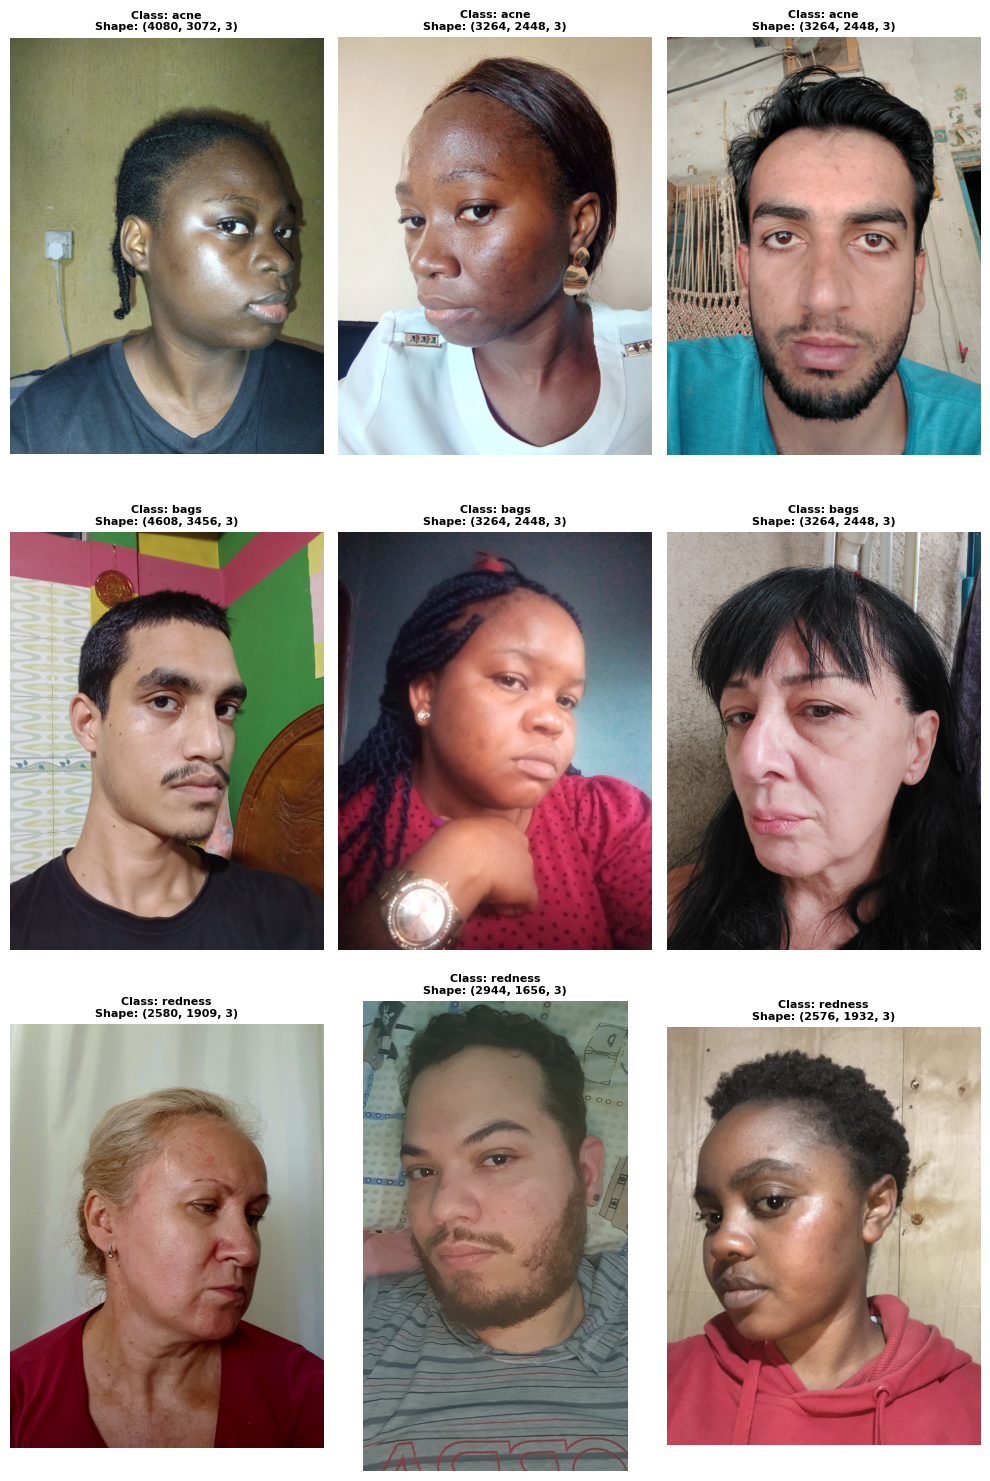

In [8]:
# We view some images for each class.
NUM_IMAGES = 3

fig, ax = plt.subplots(nrows = len(classes), ncols = NUM_IMAGES, figsize = (10,15))
p = 0
for c in classes:
    total_images_class = list(Path(os.path.join(IMAGE_PATH, c)).glob("*/*.jpg"))
    images_selected = random.choices(total_images_class, k = NUM_IMAGES)

    for i,img_path in enumerate(images_selected):
        img_bgr = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(img_rgb)
        ax[p,i].axis("off")
        ax[p,i].set_title(f"Class: {c}\nShape: {img_rgb.shape}", fontsize = 8, fontweight = "bold", color = "black")

    p += 1

fig.tight_layout()
fig.show()

# **4. Preprocessing**

Let's create a dataframe with two columns:

- the first **path** call will store the paths of the images.
- the second call **label** that will contain the labels of each image.

In [9]:
images_path = [None] * len(IMAGE_PATH_LIST)
labels = [None] * len(IMAGE_PATH_LIST)

for i,image_path in enumerate(IMAGE_PATH_LIST):
    images_path[i] = image_path
    labels[i] = image_path.parent.parent.stem

df_path_and_label = pd.DataFrame({'path':images_path,
                                  'label':labels})
df_path_and_label.head()

,path,label
0,/content/drive/MyDrive/files/bags/15/front.jpg,bags
1,/content/drive/MyDrive/files/bags/15/right_sid...,bags
2,/content/drive/MyDrive/files/bags/15/left_side...,bags
3,/content/drive/MyDrive/files/bags/18/right_sid...,bags
4,/content/drive/MyDrive/files/bags/18/left_side...,bags


Now we have to divide our dataframe into 3 parts:

- **train = 70%**
- **valid = 15%**
- **test = 15%**

In [10]:
SEED = 123

df_train, df_rest = tts(df_path_and_label,
                        test_size = 0.3,
                        random_state = SEED,
                        stratify = df_path_and_label["label"])

df_val, df_test = tts(df_rest,
                      test_size = 0.5,
                      random_state = SEED,
                      stratify = df_rest["label"])

In [11]:
# We have to define the mapping of the classes to convert the labels to numbers.
label_map = dict(zip(classes, range(0, len(classes))))
label_map

{'acne': 0, 'bags': 1, 'redness': 2}

In [12]:
# Now we define the transformations that we are going to apply.
weights = ViT_B_16_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Now we are going to create the **Dataset's** and **DataLoader's**.

Let's start with the **Dataset's**.

In [13]:
class CustomDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transforms, label_map: dict):
        """
        Custom Dataset for loading images and labels.

        Args:
            df (pd.DataFrame): DataFrame containing image paths and labels.
            transforms (callable): Transformations to apply to the images.
            label_map (dict): Mapping of labels to integers.
        """
        self.image_paths = df.iloc[:, 0].values  # Pre-fetch image paths
        self.labels = df["label"].map(label_map).values  # Map and pre-fetch labels
        self.transforms = transforms

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image_paths)

    def __getitem__(self, idx: int):
        """
        Fetches a single sample (image and label).

        Args:
            idx (int): Index of the sample.

        Returns:
            Tuple: Transformed image and corresponding label.
        """
        # Load image
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")

        # Apply transformations
        image = self.transforms(image)

        # Get label
        label = self.labels[idx]

        return image, label


In [14]:
train_dataset = CustomDataset(df_train, auto_transforms, label_map)
valid_dataset = CustomDataset(df_val, auto_transforms, label_map)

**DataLoader's**

In [15]:

# Define batch size and number of workers for parallel data loading
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()  # Utilize all available CPU cores

# DataLoader for training data
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle data for better generalization
    num_workers=NUM_WORKERS
)

# DataLoader for validation data
valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle validation data for robustness
    num_workers=NUM_WORKERS
)


In [16]:
# Visualize the dimensions of a single batch
# - batch_images: Tensor of shape [Batch_Size, Channels, Height, Width]
# - batch_labels: Tensor of shape [Batch_Size]
batch_images, batch_labels = next(iter(train_dataloader))

print("Image batch shape:", batch_images.shape)
print("Label batch shape:", batch_labels.shape)


(torch.Size([1, 3, 224, 224]), torch.Size([1]))

# **5. Model**

In [17]:
# GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [18]:
# We define the model to use with the pre-trained weights.
model = vit_b_16(weights = weights)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 121MB/s]


In [19]:
# Visualize the architecture and details of the model using the 'torchinfo.summary' function

# model: The model whose architecture needs to be visualized.
# - Ensure the model is already defined and initialized (e.g., ViT or any other neural network).

# input_size: Specifies the input dimensions fed into the model
# Shape: [Batch_Size, Channels, Height, Width]
# - Batch_Size: 1 (single input for inspection)
# - Channels: 3 (RGB images)
# - Height & Width: 224x224 (standard size for Vision Transformers)

# col_names: Defines the columns to display in the summary table
# - "input_size": Size of the input tensor at each layer
# - "output_size": Size of the output tensor at each layer
# - "num_params": Number of parameters in each layer
# - "trainable": Indicates whether the parameters are trainable (True/False)

# col_width: Sets the column width for better readability in the output

# row_settings: Specifies additional row settings
# - "var_names": Displays variable names for better identification of layers

summary(model=model,
        input_size=[1, 3, 224, 224],
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=15,
        row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 1000]       768             True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] 590,592         True
├─Encoder (encoder)                                          [1, 197, 768]   [1, 197, 768]   151,296         True
│    └─Dropout (dropout)                                     [1, 197, 768]   [1, 197, 768]   --              --
│    └─Sequential (layers)                                   [1, 197, 768]   [1, 197, 768]   --              True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]   [1, 197, 768]   7,087,872       True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]   [1, 197, 768]   7,087,872       True
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]   [1, 1

We are going to **freeze the parameters of the conv_proj and encoder layers**.

In [20]:
# Freeze the parameters of the 'conv_proj' layer in the model
for param in model.conv_proj.parameters():
    param.requires_grad = False  # Disable gradient computation for these parameters


In [22]:
# Let's see if the parameters were frozen.
summary(model = model,
        input_size = [1,3,224,224],
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 15,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 1000]       768             Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [1, 197, 768]   [1, 197, 768]   151,296         False
│    └─Dropout (dropout)                                     [1, 197, 768]   [1, 197, 768]   --              --
│    └─Sequential (layers)                                   [1, 197, 768]   [1, 197, 768]   --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]

Great!!, the parameters were frozen.

Let's visualize the last layer which we will modify the number of **out_features**, in this case it is the **number of classes we have**.

In [54]:
output_shape = len(classes)

model.heads = nn.Sequential(OrderedDict([('head', nn.Linear(in_features = 768,
                                                            out_features = output_shape))]))

In [24]:
# One last time let's take a look if the last layer was modified.
summary(model = model,
        input_size = [1,3,224,224],
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 15,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 3]          768             Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [1, 197, 768]   [1, 197, 768]   151,296         False
│    └─Dropout (dropout)                                     [1, 197, 768]   [1, 197, 768]   --              --
│    └─Sequential (layers)                                   [1, 197, 768]   [1, 197, 768]   --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]

Let's define the **loss function** and the **optimizer**.

In [25]:
# Define the loss function and optimizer for training the model

# Loss Function: CrossEntropyLoss
loss_fn = nn.CrossEntropyLoss()
# - Suitable for multi-class classification tasks.
# - Assumes the model's output is raw logits (no softmax applied).
# - Automatically applies log-softmax and computes the negative log-likelihood loss.

# Optimizer: Adam (Adaptive Moment Estimation)
optimizer = optim.Adam(model.parameters(), lr=0.01)
# - model.parameters(): Passes all model parameters (including unfrozen ones) to the optimizer.
# - lr=0.01: Learning rate, which controls the step size for parameter updates.
#   - A relatively high learning rate; you may consider reducing it (e.g., 0.001) for better convergence.


We are going to define 3 functions for training and one to store the best model:

- **train_step**
- **save_checkpoint**
- **valid_step**
- **train**

In [26]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    """
    Perform a single training step over the dataset.

    Args:
        model (torch.nn.Module): The neural network model to train.
        dataloader (torch.utils.data.DataLoader): DataLoader providing batches of data.
        loss_fn (torch.nn.Module): Loss function to compute the training loss.
        optimizer (torch.optim.Optimizer): Optimizer to update model parameters.

    Returns:
        Tuple[float, float]: Average training loss and accuracy for this step.
    """

    # Set the model to training mode (enables dropout, batch norm, etc.)
    model.train()

    # Initialize cumulative loss and accuracy
    train_loss = 0.0
    train_accuracy = 0.0

    # Iterate through batches of data
    for batch, (X, y) in enumerate(dataloader):
        # Move inputs (X) and labels (y) to the specified device (GPU/CPU)
        X, y = X.to(device), y.to(device)

        # Zero the gradients to avoid gradient accumulation
        optimizer.zero_grad()

        # Forward pass: compute raw predictions (logits)
        y_pred_logit = model(X)

        # Compute the loss between predictions and actual labels
        loss = loss_fn(y_pred_logit, y)
        train_loss += loss.item()

        # Backward pass: compute gradients
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Convert logits to class probabilities and predicted classes
        y_pred_prob = torch.softmax(y_pred_logit, dim=1)
        y_pred_class = torch.argmax(y_pred_prob, dim=1)

        # Calculate accuracy for the current batch
        train_accuracy += accuracy_score(y.cpu().numpy(),
                                         y_pred_class.detach().cpu().numpy())

    # Average loss and accuracy across all batches
    train_loss = train_loss / len(dataloader)
    train_accuracy = train_accuracy / len(dataloader)

    return train_loss, train_accuracy


In [40]:
def save_checkpoint(filename, model, loss, epoch, optimizer, metric):
    state = {
        "filename": filename,
        "model": model.state_dict(),
        "loss": loss,
        "epoch": epoch,
        "optimizer": optimizer.state_dict(),
        "metric": metric
    }

    # Save to Google Drive
    save_path = os.path.join('/content/drive/MyDrive/files/model', filename)
    torch.save(state, save_path)

In [41]:
def valid_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):
    """
    Perform a single validation step over the dataset.

    Args:
        model (torch.nn.Module): The neural network model to validate.
        dataloader (torch.utils.data.DataLoader): DataLoader providing batches of validation data.
        loss_fn (torch.nn.Module): Loss function to compute the validation loss.

    Returns:
        Tuple[float, float]: Average validation loss and accuracy for this step.
    """

    # Set the model to evaluation mode (disables dropout, batch norm updates, etc.)
    model.eval()

    # Initialize cumulative loss and accuracy
    valid_loss = 0.0
    valid_accuracy = 0.0

    # Disable gradient computation for inference to save memory and computation
    with torch.inference_mode():
        # Iterate through batches of data
        for batch, (X, y) in enumerate(dataloader):
            # Move inputs (X) and labels (y) to the specified device (GPU/CPU)
            X, y = X.to(device), y.to(device)

            # Forward pass: compute raw predictions (logits)
            y_pred_logit = model(X)

            # Compute loss between predictions and actual labels
            loss = loss_fn(y_pred_logit, y)
            valid_loss += loss.item()

            # Convert logits to class probabilities and predicted classes
            y_pred_prob = torch.softmax(y_pred_logit, dim=1)
            y_pred_class = torch.argmax(y_pred_prob, dim=1)

            # Calculate accuracy for the current batch
            valid_accuracy += accuracy_score(y.cpu().numpy(),
                                             y_pred_class.detach().cpu().numpy())

    # Average loss and accuracy across all batches
    valid_loss = valid_loss / len(dataloader)
    valid_accuracy = valid_accuracy / len(dataloader)

    return valid_loss, valid_accuracy


In [42]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          valid_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int = 10):
    """
    Function to train and validate a model over a given number of epochs.

    Args:
        model (torch.nn.Module): The neural network model to train.
        train_dataloader (torch.utils.data.DataLoader): DataLoader for training data.
        valid_dataloader (torch.utils.data.DataLoader): DataLoader for validation data.
        loss_fn (torch.nn.Module): Loss function for training and validation.
        optimizer (torch.optim.Optimizer): Optimizer to update model parameters.
        epochs (int): Number of epochs to train the model (default: 10).

    Returns:
        dict: A dictionary containing training and validation loss and accuracy history.
    """

    # Dictionary to store training and validation metrics across epochs
    results = {"train_loss": [],
               "train_accuracy": [],
               "valid_loss": [],
               "valid_accuracy": []}

    # Initialize the best validation loss to a very large value
    best_valid_loss = float("inf")

    # Training loop across epochs
    for epoch in tqdm(range(epochs)):  # Show progress bar for epochs
        # Perform one training step
        train_loss, train_accuracy = train_step(model=model,
                                                dataloader=train_dataloader,
                                                loss_fn=loss_fn,
                                                optimizer=optimizer)

        # Perform one validation step
        valid_loss, valid_accuracy = valid_step(model=model,
                                                dataloader=valid_dataloader,
                                                loss_fn=loss_fn)

        # Save the model if the current validation loss is the best so far
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            file_name = "best_model.pth"
            save_checkpoint(file_name, model, best_valid_loss, epoch, optimizer, valid_accuracy)

        # Print progress for the current epoch
        print(f"Epoch: {epoch + 1} | ",
              f"Train Loss: {train_loss:.4f} | ",
              f"Train Accuracy: {train_accuracy:.4f} | ",
              f"Valid Loss: {valid_loss:.4f} | ",
              f"Valid Accuracy: {valid_accuracy:.4f}")

        # Store results for tracking progress
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        results["valid_loss"].append(valid_loss)
        results["valid_accuracy"].append(valid_accuracy)

    return results


In [43]:
# ============================
# Training the Model
# ============================

# Define the number of epochs for training
EPOCHS = 5

# Set random seeds for reproducibility
torch.cuda.manual_seed(SEED)  # Set seed for CUDA (GPU)
torch.manual_seed(SEED)       # Set seed for CPU

# Call the train function to start the training process
MODEL_RESULTS = train(model.to(device),   # Move the model to the specified device (GPU/CPU)
                      train_dataloader,   # DataLoader for training data
                      valid_dataloader,   # DataLoader for validation data
                      loss_fn,            # Loss function for training and validation
                      optimizer,          # Optimizer to update model parameters
                      EPOCHS)             # Number of training epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 0.0562 |  Train Accuracy: 1.0000 |  Valid Loss: 0.6459 |  Valid Accuracy: 0.9231
Epoch: 2 |  Train Loss: 0.0252 |  Train Accuracy: 1.0000 |  Valid Loss: 0.8625 |  Valid Accuracy: 0.8462
Epoch: 3 |  Train Loss: 0.0134 |  Train Accuracy: 1.0000 |  Valid Loss: 0.5470 |  Valid Accuracy: 0.9231
Epoch: 4 |  Train Loss: 0.0159 |  Train Accuracy: 1.0000 |  Valid Loss: 0.5793 |  Valid Accuracy: 0.8462
Epoch: 5 |  Train Loss: 0.0019 |  Train Accuracy: 1.0000 |  Valid Loss: 0.6582 |  Valid Accuracy: 0.8462


In [44]:
# Function to plot the loss and accuracy curves during each training epoch
def loss_metric_curve_plot(model_results: Dict[str, List[float]]):
    """
    Plots the training and validation loss and accuracy curves.

    Args:
        model_results (Dict[str, List[float]]): Dictionary containing:
            - "train_loss": List of training losses per epoch.
            - "valid_loss": List of validation losses per epoch.
            - "train_accuracy": List of training accuracies per epoch.
            - "valid_accuracy": List of validation accuracies per epoch.

    Returns:
        None. Displays the plots of loss and accuracy curves.
    """

    # Extract loss and accuracy data
    train_loss = model_results["train_loss"]
    valid_loss = model_results["valid_loss"]

    # Convert accuracies to floats for safety
    train_accuracy = [float(value) for value in model_results["train_accuracy"]]
    valid_accuracy = [float(value) for value in model_results["valid_accuracy"]]

    # Create subplots: one for loss and one for accuracy
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  # 1 row, 2 columns
    axes = axes.flat  # Flatten axes for easier iteration

    # Plot Loss Curves
    axes[0].plot(train_loss, color="red", label="Train")
    axes[0].plot(valid_loss, color="blue", label="Valid")
    axes[0].set_title("CrossEntropyLoss", fontsize=12, fontweight="bold", color="black")
    axes[0].set_xlabel("Epochs", fontsize=10, fontweight="bold", color="black")
    axes[0].set_ylabel("Loss", fontsize=10, fontweight="bold", color="black")
    axes[0].legend()

    # Plot Accuracy Curves
    axes[1].plot(train_accuracy, color="red", label="Train")
    axes[1].plot(valid_accuracy, color="blue", label="Valid")
    axes[1].set_title("Metric of Performance: Accuracy", fontsize=12, fontweight="bold", color="black")
    axes[1].set_xlabel("Epochs", fontsize=10, fontweight="bold", color="black")
    axes[1].set_ylabel("Score", fontsize=10, fontweight="bold", color="black")
    axes[1].legend()

    # Adjust subplot layout for better spacing
    fig.tight_layout()

    # Display the plots
    fig.show()


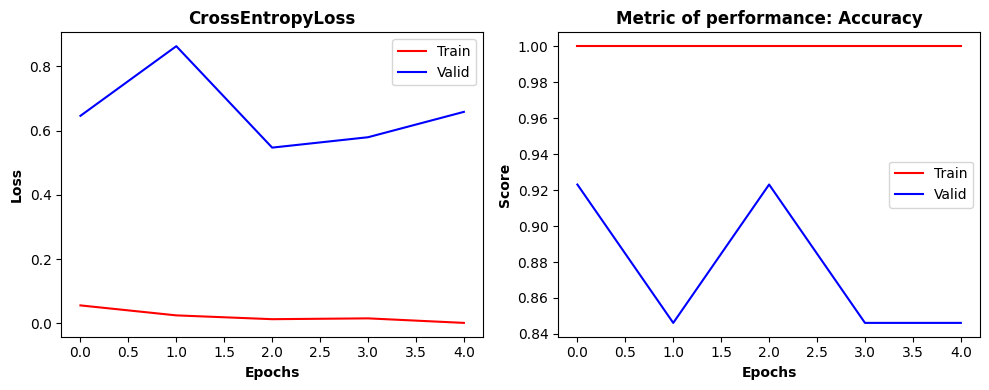

In [45]:
loss_metric_curve_plot(MODEL_RESULTS)

In [46]:
# Let's load the best model.
checkpoint_path = "/content/drive/MyDrive/files/model/best_model.pth"
checkpoint = torch.load(checkpoint_path)

In [47]:
# Now let's look at the smallest loss, its metric and when it occurred.
print(f'Best Loss: {checkpoint["loss"]}')
print(f'Epoch: {checkpoint["epoch"] + 1}')
print(f'Best Metric: {checkpoint["metric"]}')

Best Loss: 0.5469860633456847
Epoch: 3
Best Metric: 0.9230769230769231


Well, now we have to predict the images of the test set.

- **Predictions**

In [36]:
# First of all, we create the Dataset, DataLoader
test_dataset = CustomDataset(df_test, auto_transforms, label_map)
test_dataloader = DataLoader(dataset = test_dataset, shuffle = False, num_workers = NUM_WORKERS)

In [48]:
# ============================
# Model Definition and Inference
# ============================

# Define the model architecture (Vision Transformer with a modified classification head)
loaded_model = vit_b_16()  # Load the Vision Transformer base model

# Replace the model's classification head to match the number of target classes
loaded_model.heads = nn.Sequential(OrderedDict([
    ('head', nn.Linear(in_features=768, out_features=output_shape))  # Custom linear head
]))

# Load the saved model's state dictionary (pretrained weights and parameters)
loaded_model.load_state_dict(checkpoint["model"])

# Move the model to the specified device (CPU or GPU)
loaded_model.to(device)

# Set the model to evaluation mode (disables dropout, batch norm updates, etc.)
loaded_model.eval()

# List to store the predicted classes for the test set
y_pred_test = []

# Inference loop (no gradient computation to save memory and computation time)
with torch.inference_mode():
    for X, y in tqdm(test_dataloader):  # Iterate through test batches
        # Move input data and labels to the specified device
        X, y = X.to(device), y.to(device)

        # Forward pass: Get model predictions (logits)
        y_pred_logit = loaded_model(X)

        # Convert logits to class probabilities
        y_pred_prob = torch.softmax(y_pred_logit, dim=1)

        # Extract the predicted class with the highest probability
        y_pred_class = torch.argmax(y_pred_prob, dim=1)

        # Append predictions (moved to CPU) to the results list
        y_pred_test.append(y_pred_class.detach().cpu())


  0%|          | 0/14 [00:00<?, ?it/s]

In [49]:
y_pred_test = torch.cat(y_pred_test).numpy()

# **6. Metrics**

- **Accuracy**

In [50]:
print(f'Accuracy = {round(accuracy_score(df_test["label"].map(label_map), y_pred_test), 4)}')

Accuracy = 0.7857


- **Confusion Matrix**

In [51]:
confusion_matrix_test = confusion_matrix(df_test["label"].map(label_map), y_pred_test)

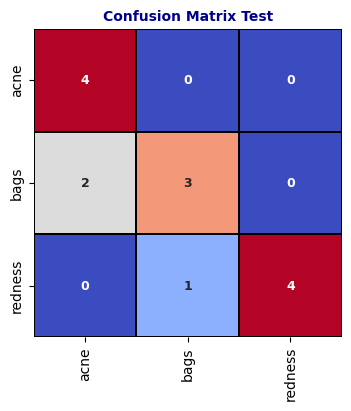

In [52]:
fig,ax = plt.subplots(figsize = (15,4))
sns.heatmap(confusion_matrix_test,
            cmap = 'coolwarm',
            annot = True,
            annot_kws = {"fontsize":9, "fontweight":"bold"},
            linewidths = 1.2,
            linecolor = "black",
            square = True,
            xticklabels = classes,
            yticklabels = classes,
            cbar = False,
            ax = ax)
ax.set_title("Confusion Matrix Test", fontsize = 10, fontweight = "bold", color = "darkblue")
ax.tick_params('x',rotation = 90)
fig.show()

In [59]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
from torchvision.models import vit_b_16
from collections import OrderedDict
import numpy as np

# Define transformations (adjust as needed for your model)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model = vit_b_16()

#  Set out_features to match the number of classes used during training (len(classes))
loaded_model.heads = nn.Sequential(OrderedDict([
    ('head', nn.Linear(in_features=768, out_features=len(classes)))
]))
checkpoint_path = "/content/drive/MyDrive/files/model/best_model.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
loaded_model.load_state_dict(checkpoint["model"])
loaded_model.to(device)
loaded_model.eval()

# Function to predict the image
def predict_image(image_path):
  try:
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = loaded_model(img_tensor)
        probabilities = torch.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()

    return predicted_class

  except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
    return None
  except Exception as e:
    print(f"An error occurred: {e}")
    return None

# Example usage:
image_path = "/content/Acne-The-Dermatology-Clinic-London-scaled.webp" # Replace with the actual path
predicted_class = predict_image(image_path)

if predicted_class is not None:
  print(f"Predicted class: {predicted_class}")

Predicted class: 0
